In [144]:
import sys
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
import matplotlib.pyplot as plt
from PySide6.QtWidgets import QApplication
from temgymbasic.gui import TemGymWindow

import numpy as np
from temgymbasic.utils import calculate_phi_0
from temgymbasic import gbd

from typing import Tuple, NamedTuple
from temgymbasic.plotting import plot_model
%matplotlib ipympl

In [145]:
def make_detector_for_gauss_rays(x_det, y_det, n_rays):
    x,y = np.meshgrid(x_det, y_det)
    
    r = np.array([x.ravel(), y.ravel()]).T
    r = np.broadcast_to(r, [n_rays, *r.shape])
    r = np.swapaxes(r, 0, 1)
    

    return r


In [146]:
n_rays = 100
wavelength = 0.001
k = 2 * np.pi / wavelength

wavelengths = np.full(n_rays, wavelength)

a = 10
b = 5

size = 256
det_shape = (size, size)
pixel_size = 1 / size
dsize = det_shape[0] * pixel_size

x_det = np.linspace(-dsize / 2, dsize / 2, size)

theta_x = 0
theta_y = 0

deg_yx = np.deg2rad((theta_y, theta_x ))
tilt_yx = np.tan(deg_yx)

wo = 0.01
wos = np.full(n_rays, wo)

div = wavelength / (np.pi * wo)

dPx = wo
dPy = wo
dHx = div
dHy = div

z_r = (np.pi * wo ** 2) / wavelengths 

x0 = 0.1
y0 = 0

coeffs = [0.01, 0.0, 0, 0, 0]

In [147]:
components = (
    # comp.PointBeam(
    #     z=0.0,
    #     voltage=calculate_phi_0(wavelength),
    #     semi_angle = 0.01,
    #     tilt_yx=tilt_yx
    # ),
    comp.GaussBeam(
        z=0.0,
        voltage=calculate_phi_0(wavelength),
        radius=x0,
        wo=wo,
        tilt_yx=tilt_yx
    ),
    # comp.PerfectLens(
    #     z = a,
    #     f = 10,
    #     z1 = -a,
    #     z2 = b,
    # ),
    comp.AberratedLens(
        z = a,
        f = 1,
        z1 = -a,
        z2 = b,
        coeffs=coeffs,
    ),
    comp.AccumulatingDetector(
        z=a + b,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=4,
        ray_type='Gauss'
    ),
)



In [148]:
model = Model(components)
print(model.components[1]._m)
rays = tuple(model.run_iter(num_rays=n_rays))
image = model.detector.get_image(rays)
det_x = np.linspace(-det_shape[1]//2*pixel_size, det_shape[1]//2*pixel_size, det_shape[1])

-0.5


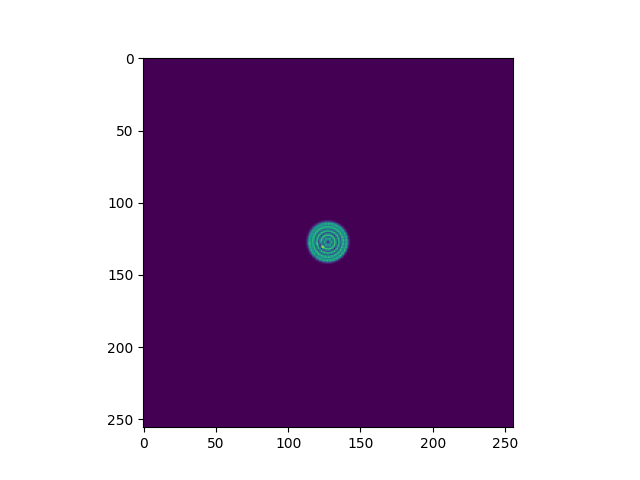

In [149]:
plt.figure()
plt.imshow(image)

In [150]:
end_rays = rays[-1].data[0:4, :].T
path_length = rays[-1].path_length[0::5]

split_end_rays = np.split(end_rays, n_rays, axis=0)

rayset1 = np.stack(split_end_rays, axis=-1)

xEnd, yEnd = rayset1[0, 0], rayset1[0, 2]
lEnd, mEnd = rayset1[0, 1], rayset1[0, 3]

phi_x2m = rays[-2].data[1, 0::5]
phi_y2m = rays[-2].data[3, 0::5]

p2m = np.array([phi_x2m, phi_y2m]).T
r2 = make_detector_for_gauss_rays(x_det, x_det, n_rays)
r = r2.copy()

r[:, :,  0] = r2[:, :,  0] - xEnd
r[:, :,  1] = r2[:, :,  1] - yEnd

A, B, C, D = gbd.differential_matrix(rayset1, dPx, dPy, dHx, dHy)
Qinv = gbd.calculate_Qinv(z_r)
Qpinv = gbd.calculate_Qpinv(A, B, C, D, Qinv)
field = gbd.propagate_misaligned_gaussian(Qinv, Qpinv, r, p2m.T, k, A, B, path_length).reshape(det_shape)
# field = zero_phase(field, size//2, size//2)

Text(0.5, 0.98, 'GBP')

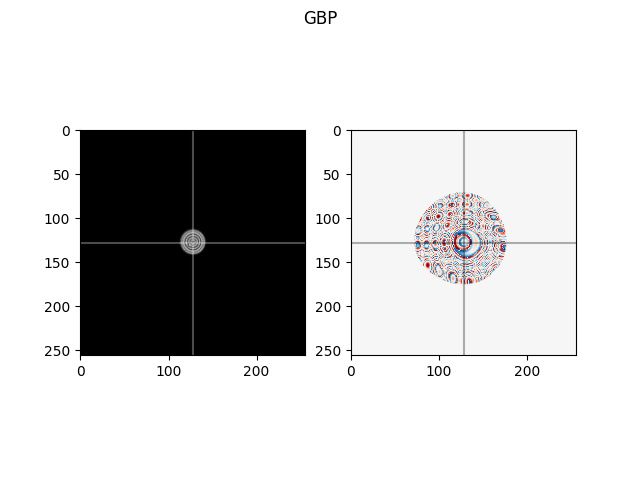

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.abs(field),cmap='gray')
ax1.axvline(size // 2, color='white', alpha=0.3)
ax1.axhline(size // 2, color='white', alpha=0.3)
ax2.imshow(np.angle(field),cmap='RdBu')
ax2.axvline(size // 2, color='k', alpha=0.3)
ax2.axhline(size // 2, color='k', alpha=0.3)
fig.suptitle("GBP")